<a href="https://colab.research.google.com/github/PeterYves/DIC-ML-Assignmnent/blob/main/Sprint_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **`[Problem 1] Share and execute the official tutorial model`**

---

- We have used the time series forecasting using Recurrent Neural Networks (RNN), From the Tensoflow official tutorial models.
> https://www.tensorflow.org/tutorials/structured_data/time_series



In [62]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [63]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [64]:
df = pd.read_csv(csv_path)

In [65]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [66]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [67]:
TRAIN_SPLIT = 300000

In [68]:
tf.random.set_seed(13)

- On the first PART the univariate time series is forecasted

In [69]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<Axes: xlabel='Date Time'>], dtype=object)

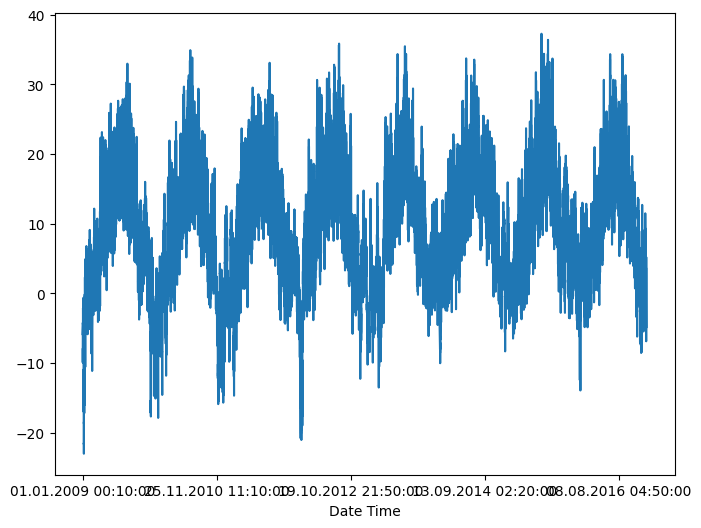

In [70]:
uni_data.plot(subplots=True)

- The above is how the data looks across time

In [71]:
uni_data = uni_data.values

In [72]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [73]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [74]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [75]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [76]:
def create_time_steps(length):
  return list(range(-length, 0))

In [77]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

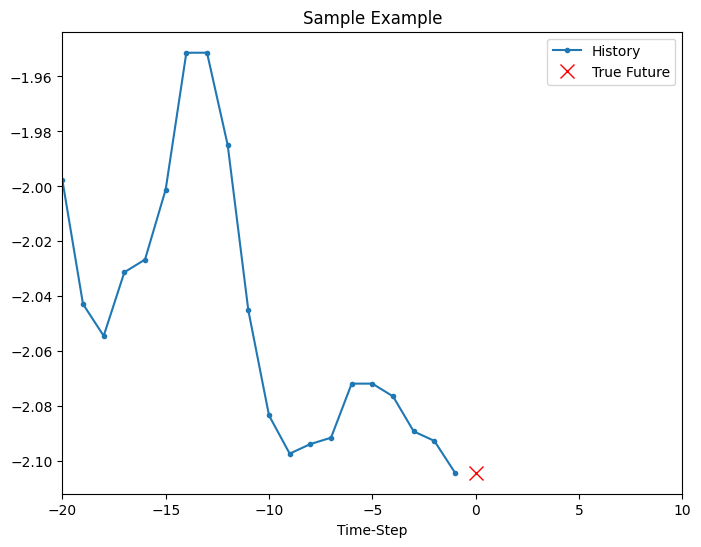

In [78]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [79]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

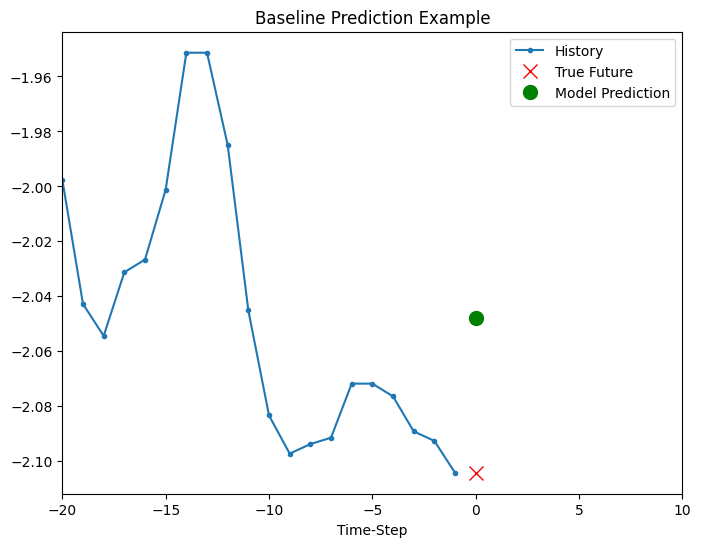

In [80]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Now the recurrent neural network comes into account

In [81]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [82]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [83]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 0s 3ms/step
(256, 1)


In [84]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 7ms/step - loss: 0.2320 - val_loss: 0.0464
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0626 - val_loss: 0.0284
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0380 - val_loss: 0.0262
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0362 - val_loss: 0.0224
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0249 - val_loss: 0.0208
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0271 - val_loss: 0.0191
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0244 - val_loss: 0.0182
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0229 - val_loss: 0.0180
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0222 - val_loss: 0.0164
Epoch 10/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0202 - val_loss: 0.0155

8/8 [==============================] - 0s 3ms/step


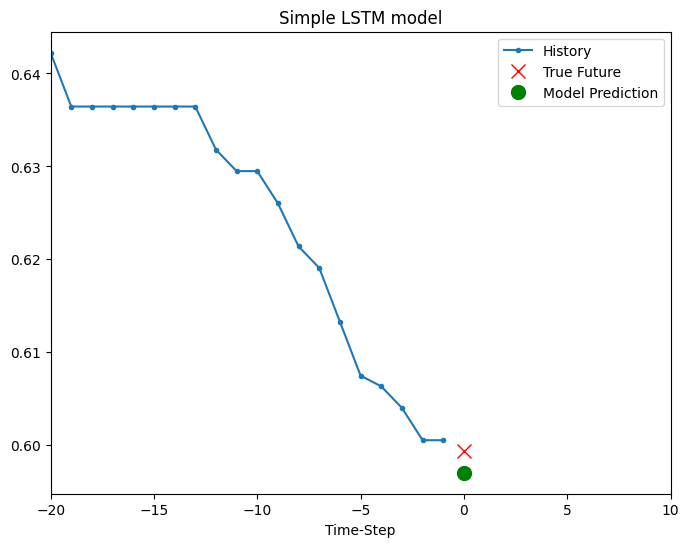

8/8 [==============================] - 0s 2ms/step


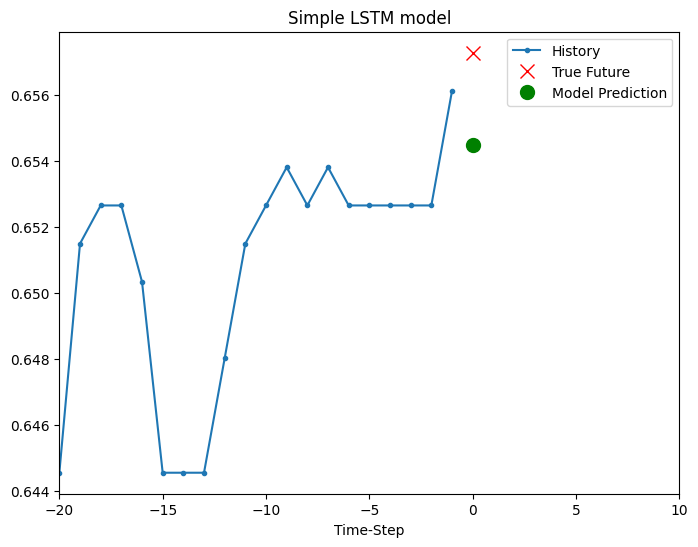

8/8 [==============================] - 0s 2ms/step


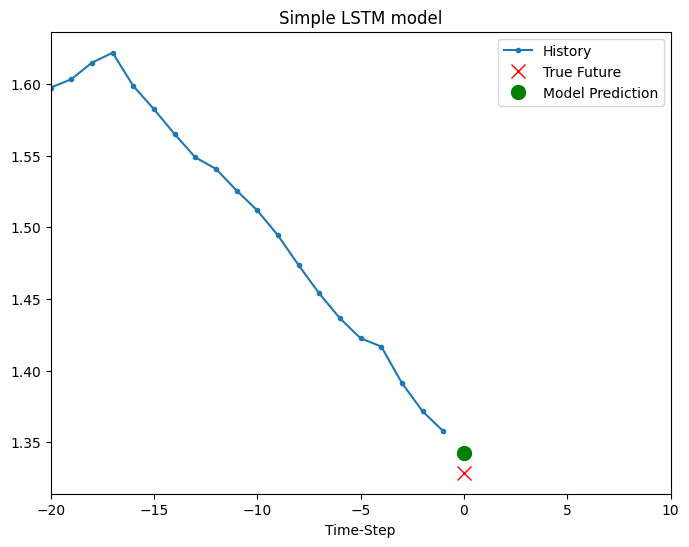

In [85]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

- The above part handled the univariable, let's now move to the multivariable forecasting

In [86]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [87]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

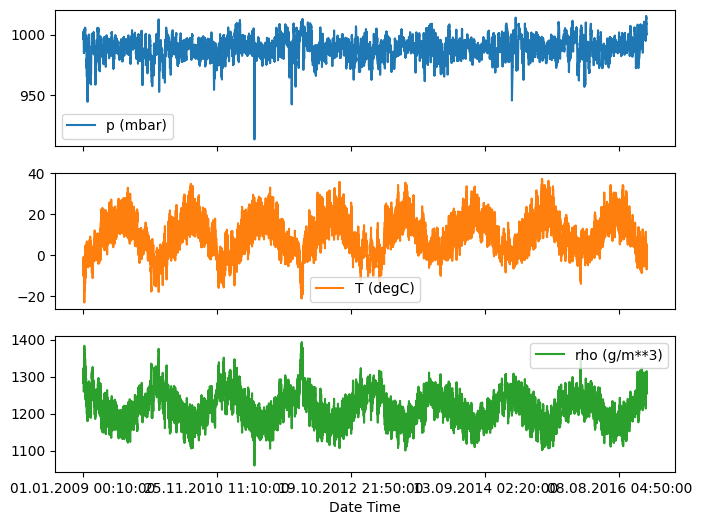

In [88]:
features.plot(subplots=True)

The above shows how each of the features vary across the time

In [89]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [90]:
dataset = (dataset-data_mean)/data_std

In [91]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [92]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [93]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (120, 3)


In [94]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [95]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [96]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 [==============================] - 0s 5ms/step
(256, 1)


In [97]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 13ms/step - loss: 0.3043 - val_loss: 0.2578
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2601 - val_loss: 0.2345
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2607 - val_loss: 0.2417
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2580 - val_loss: 0.2349
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2286 - val_loss: 0.2306
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2417 - val_loss: 0.2559
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2421 - val_loss: 0.2583
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2417 - val_loss: 0.2496
Epoch 9/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2459 - val_loss: 0.2406
Epoch 10/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2405 - val_loss: 0.2

In [98]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

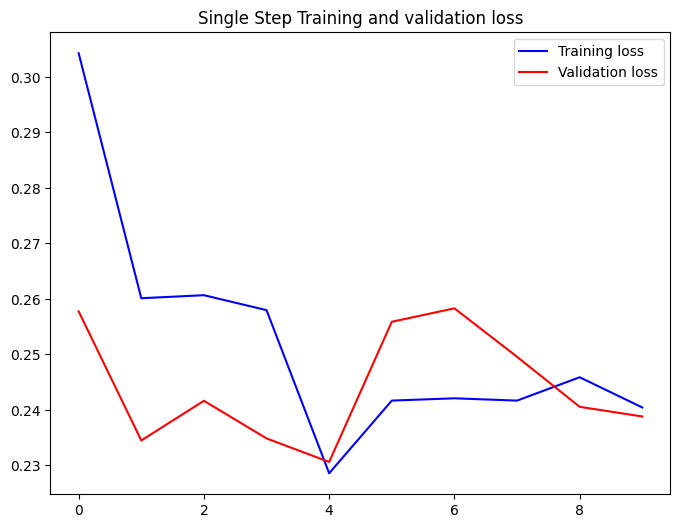

In [99]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

- Predicting a single step feature


8/8 [==============================] - 0s 3ms/step


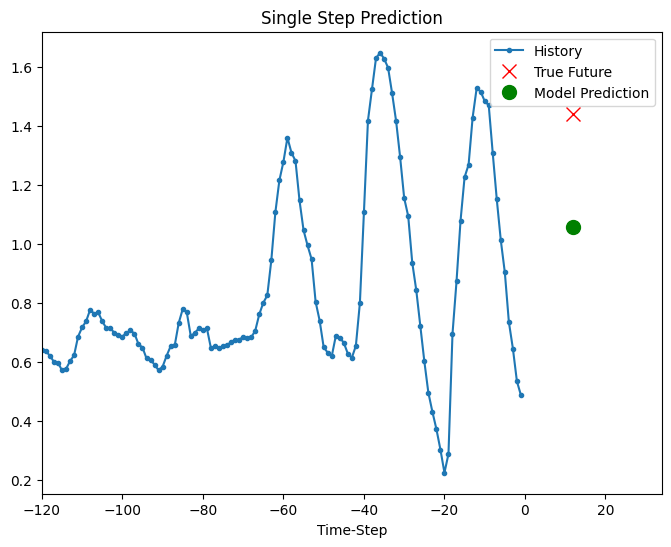

8/8 [==============================] - 0s 4ms/step


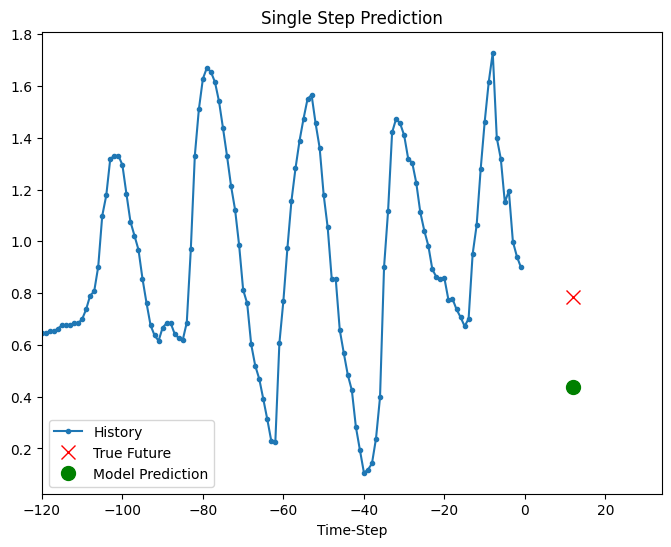

8/8 [==============================] - 0s 3ms/step


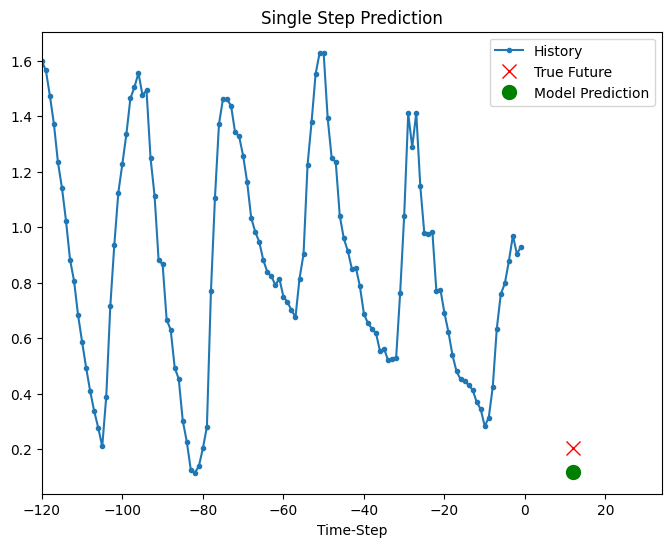

In [100]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

- Multi -Step model


In [101]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [102]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [103]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [104]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

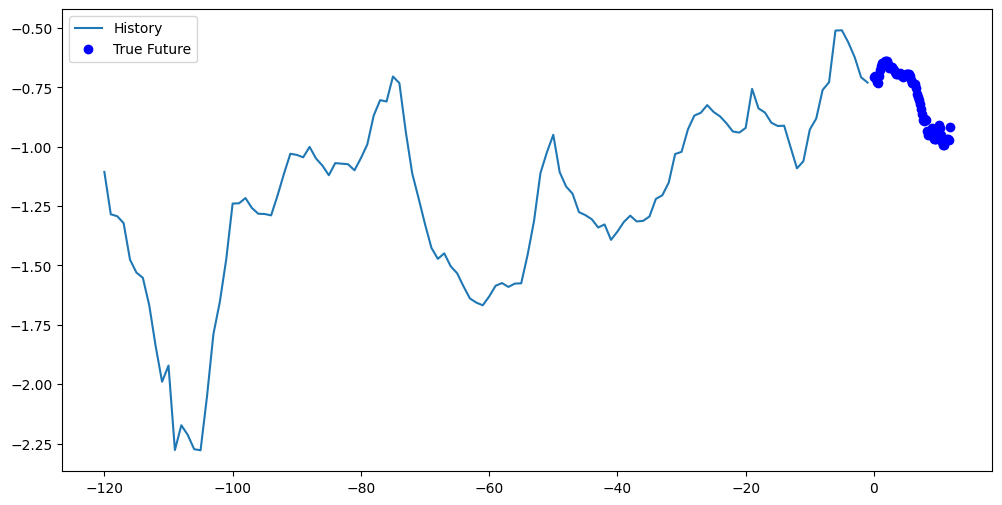

In [105]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [106]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [107]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 [==============================] - 1s 19ms/step
(256, 72)


In [108]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 53s 248ms/step - loss: 15.4980 - val_loss: 0.2928
Epoch 2/10
200/200 [==============================] - 49s 244ms/step - loss: 0.3345 - val_loss: 0.2692
Epoch 3/10
200/200 [==============================] - 49s 243ms/step - loss: 49.1421 - val_loss: 0.2474
Epoch 4/10
200/200 [==============================] - 49s 244ms/step - loss: 0.2492 - val_loss: 0.2104
Epoch 5/10
200/200 [==============================] - 50s 249ms/step - loss: 0.2040 - val_loss: 0.1988
Epoch 6/10
200/200 [==============================] - 49s 243ms/step - loss: 0.2150 - val_loss: 0.2201
Epoch 7/10
200/200 [==============================] - 47s 237ms/step - loss: 0.2067 - val_loss: 0.1978
Epoch 8/10
200/200 [==============================] - 47s 235ms/step - loss: 0.2041 - val_loss: 0.2053
Epoch 9/10
200/200 [==============================] - 49s 245ms/step - loss: 0.2062 - val_loss: 0.1926
Epoch 10/10
200/200 [==============================] - 49s 248ms/step -

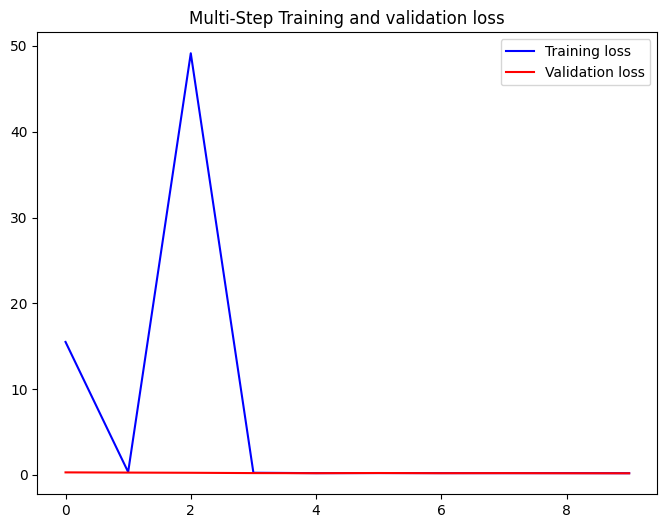

In [109]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


- Predicting a multi-step feature


8/8 [==============================] - 0s 20ms/step


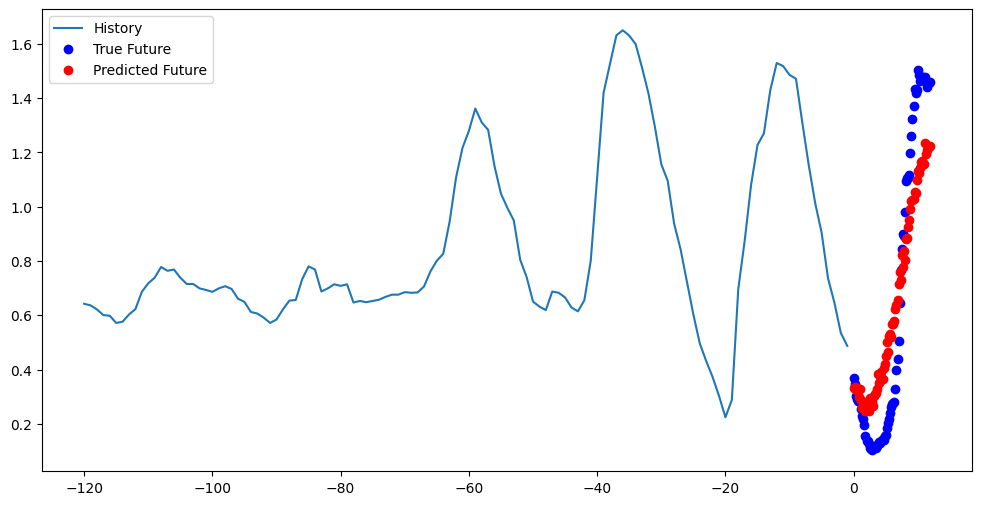

8/8 [==============================] - 0s 20ms/step


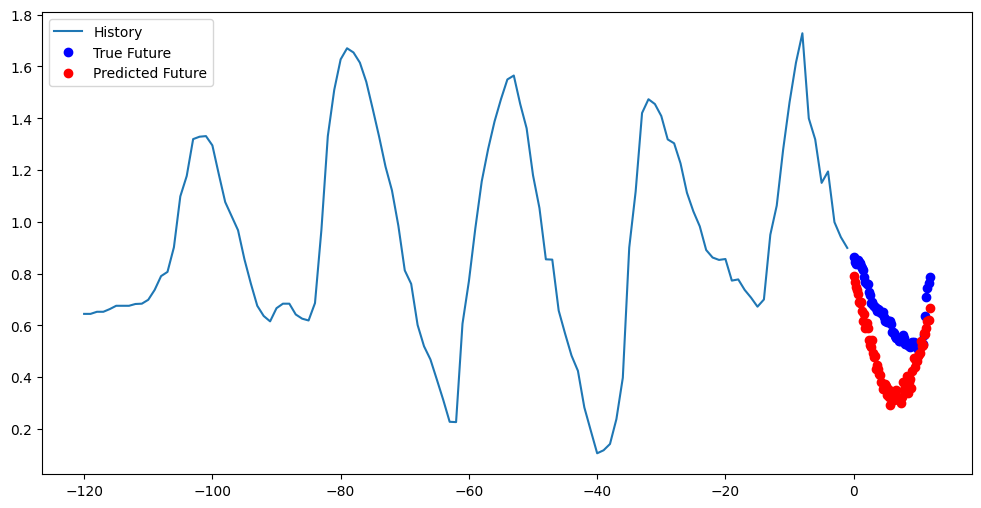

8/8 [==============================] - 0s 32ms/step


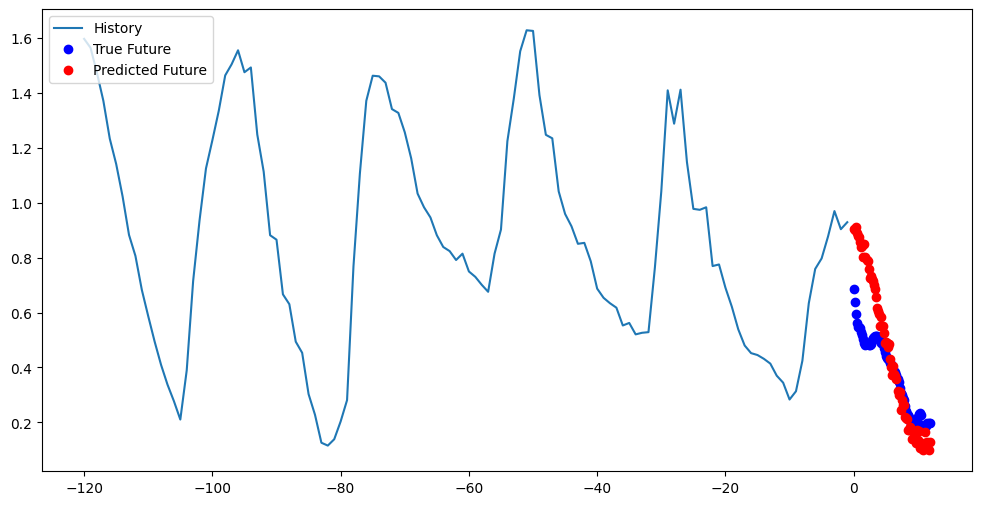

In [110]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

Like we stated above, this was quick introduction to time series forecasting using an RNN



### **`[Problem 3] Learning Iris (binary classification) with Keras`**

---



In [111]:
import numpy as np
import pandas as pd
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.optimizers import Adam # - Works

df = pd.read_csv("Iris.csv")

df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

<ipython-input-111-8f6831ba62b2>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.int)[:, np.newaxis]


In [112]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [113]:
K.clear_session( )

In [114]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation = tf.nn.sigmoid))

In [115]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                250       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,451
Trainable params: 5,451
Non-trainable params: 0
_________________________________________________________________


In [116]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=10,
                    verbose=1,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Epoch 1/10
7/7 [==============================] - 2s 33ms/step - loss: 0.9503 - accuracy: 0.6250 - val_loss: 0.7012 - val_accuracy: 0.6250
Epoch 2/10
7/7 [==============================] - 0s 10ms/step - loss: 0.7425 - accuracy: 0.5000 - val_loss: 0.6249 - val_accuracy: 0.4375
Epoch 3/10
7/7 [==============================] - 0s 8ms/step - loss: 0.6260 - accuracy: 0.5625 - val_loss: 0.5528 - val_accuracy: 0.8125
Epoch 4/10
7/7 [==============================] - 0s 11ms/step - loss: 0.5914 - accuracy: 0.6094 - val_loss: 0.4425 - val_accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 0s 8ms/step - loss: 0.4513 - accuracy: 0.8906 - val_loss: 0.4315 - val_accuracy: 0.8125
Epoch 6/10
7/7 [==============================] - 0s 8ms/step - loss: 0.3849 - accuracy: 0.8906 - val_loss: 0.2801 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 0s 8ms/step - loss: 0.2737 - accuracy: 0.9531 - val_loss: 0.1927 - val_accuracy: 1.0000
Epoch 8/10
7/7 [===============

In [117]:
y_pred_proba = model.predict(X_test)[:, 0]
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print('y_test', y_test.ravel())
     

1/1 [==============================] - 0s 72ms/step
y_pred_proba [0.09355171 0.9983102  0.08967929 0.99840695 0.94712013 0.99835616
 0.5299796  0.9006462  0.99893934 0.98628783 0.9905539  0.9938207
 0.99813867 0.309071   0.01635848 0.03760825 0.73525107 0.01829285
 0.9443777  0.03471747]
y_pred [0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0]
y_test [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]


In [118]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.2919984757900238
Train accuracy: 0.8500000238418579


### **`[Problem 4] Learn Iris (multi-level classification) with Keras`**

---



In [119]:
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv("Iris.csv")

y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int64)[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train)
y_val_one_hot = enc.transform(y_val)
y_test_one_hot = enc.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [120]:
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))

In [121]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                250       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 5,653
Trainable params: 5,653
Non-trainable params: 0
_________________________________________________________________


In [122]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

history = model.fit(X_train, y_train_one_hot,
                    batch_size=10,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val, y_val_one_hot))

In [123]:
y_pred_proba = model.predict(X_test)[:, 0]
y_pred = np.where(y_pred_proba >0.5, 1, 0)

print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

1/1 [==============================] - 0s 54ms/step
y_pred_proba [1.6184007e-09 1.7212633e-03 9.9949443e-01 1.1999049e-08 9.9747109e-01
 1.5093765e-11 9.9824107e-01 6.3295639e-04 2.8006081e-04 4.5730025e-03
 1.6866947e-07 1.4082793e-03 4.0515335e-04 3.6621041e-04 2.8772175e-04
 9.9543375e-01 4.4804715e-04 4.4265506e-04 9.9408519e-01 9.9913365e-01
 1.0789723e-07 3.3251906e-04 9.9397546e-01 9.9330574e-01 2.2718030e-05
 9.9892884e-01 9.9687636e-01 2.0579004e-03 1.7573403e-02 9.9628395e-01]
y_pred [0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1]
y_test [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]


In [124]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

1/1 [==============================] - 0s 18ms/step
y_pred [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]
y_test [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]


In [125]:
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.044932786375284195
Train accuracy: 1.0


### **`[Problem 5] Learning House Prices with Keras`**

---



In [126]:
from sklearn.preprocessing import StandardScaler

train = pd.read_csv('train.csv')

x = train[['GrLivArea', 'YearBuilt']]
y = train[['SalePrice']]

x = np.log(x).values
y = np.log(y).values

sc = StandardScaler()
sc.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

FileNotFoundError: ignored

In [ ]:
K.clear_session( )

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(2,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation = tf.keras.activations.linear))

In [ ]:
model.summary()
     

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.compile(loss='mse',
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=['mse'])
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=20,
                    verbose=1,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))
     

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba
print("y_pred", y_pred.ravel()[:5])
print('y_test', y_test.ravel()[:5])

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('loss (test):', score[0])
print('Mean Squared Error (test):', score[1])

### **`[Problem 6] Learning MNIST with Keras`**

---



In [ ]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
X_train /= 255
X_test /= 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [ ]:
K.clear_session( )

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(784,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.005),
              metrics=['accuracy'])
history = model.fit(X_train, y_train_one_hot,
                    batch_size=20,
                    epochs=5,
                    verbose=1,
                    validation_data=(X_val, y_val_one_hot))

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred", y_pred[:10])
print('y_test', y_test.ravel()[:10])

In [ ]:
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### **`[Problem 7] (Advance assignment) Rewriting to PyTorch`**

---



In [ ]:
#import data
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

The torchvision.datasets module contains Dataset objects for many real-world vision data like CIFAR, COCO (full list here). In this tutorial, we use the FashionMNIST dataset. Every TorchVision Dataset includes two arguments: transform and target_transform to modify the samples and labels respectively.

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

**Creating Models**

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

**Optimizing the Model Parameters**

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single learning loop, the model makes predictions on the training dataset (which is provided to it in batches), and back-propagates the prediction error to adjust the model parameters.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the performance of the model against the test data set to ensure that it is learning well.

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The learning process takes place over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the accuracy and loss of the model at each epoch; we would like to see the accuracy increase and the loss decrease at each epoch.

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

**Saving Models**

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

**Loading Models**

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')